In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal as sig
from wettbewerb import load_references
import CNN_dataset

In [ ]:
training_folder = "../shared_data/training_mini"
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder)

In [ ]:
CNN_dataset.create_cnn_dataset_map(ids, channels, data, sampling_frequencies, reference_systems, eeg_labels)

In [ ]:
import torch 

dataset = torch.load("cnn_map_dataset.pt")
x, y = dataset[12]

print("Label:", y.item() if torch.is_tensor(y) else y)
print("Input shape:", x.shape)
print("Feature map:\n", x[0])

/tmp/ipykernel_2452591/3741701942.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)


Dataset geladen
Label distribution: Counter({0: 58870, 1: 57})
postiv 57, negative 57
Epoch 01 | Train Loss: 1.3210 | Train Acc: 0.5165 | Test Acc: 0.5217
Epoch 02 | Train Loss: 1.0769 | Train Acc: 0.5385 | Test Acc: 0.5217
Epoch 03 | Train Loss: 0.5450 | Train Acc: 0.7582 | Test Acc: 0.5217
Epoch 04 | Train Loss: 0.3615 | Train Acc: 0.8242 | Test Acc: 0.7391
Epoch 05 | Train Loss: 0.2197 | Train Acc: 0.9231 | Test Acc: 0.7391
Epoch 06 | Train Loss: 0.1105 | Train Acc: 0.9341 | Test Acc: 0.7391
Epoch 07 | Train Loss: 0.0462 | Train Acc: 0.9890 | Test Acc: 0.6957
Epoch 08 | Train Loss: 0.0063 | Train Acc: 1.0000 | Test Acc: 0.6957
Epoch 09 | Train Loss: 0.0839 | Train Acc: 0.9670 | Test Acc: 0.7391
Epoch 10 | Train Loss: 0.0874 | Train Acc: 0.9890 | Test Acc: 0.7391
Epoch 11 | Train Loss: 0.0016 | Train Acc: 1.0000 | Test Acc: 0.7826
Epoch 12 | Train Loss: 0.3005 | Train Acc: 0.9560 | Test Acc: 0.7826
Epoch 13 | Train Loss: 0.1118 | Train Acc: 0.9670 | Test Acc: 0.6522
Epoch 14 | Train 

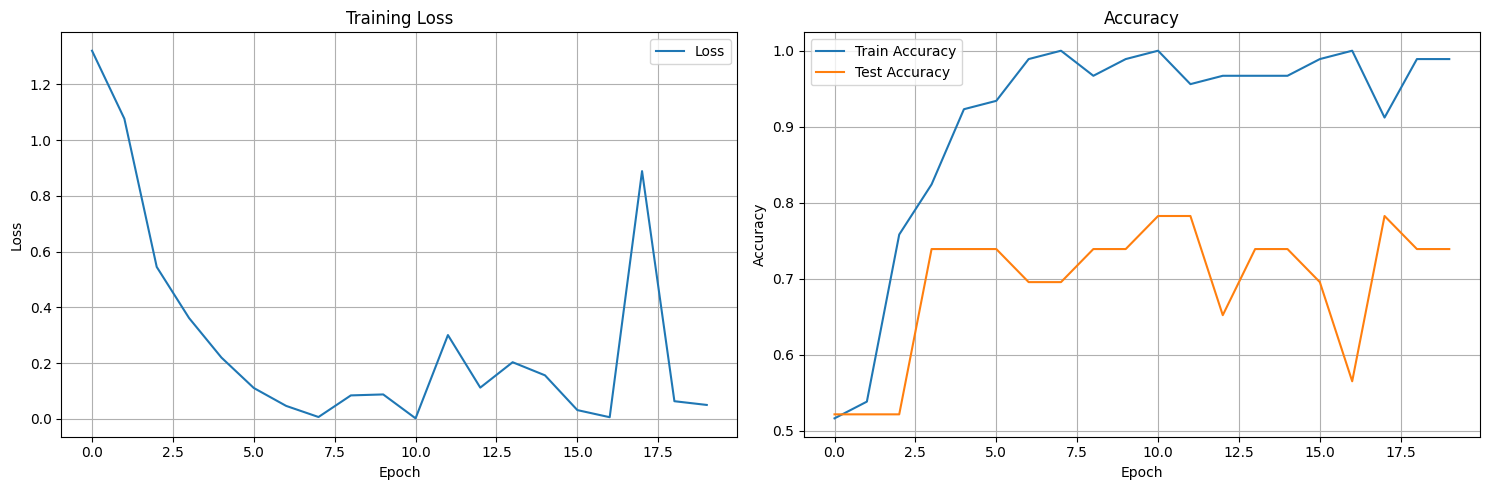

In [4]:
import random
import torch
import os
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from collections import Counter
dataset_path = "cnn_map_dataset.pt"
if not os.path.exists(dataset_path):
    raise FileNotFoundError("Run CNN_dataset.py, um Dataset zu erstellen")
    
dataset = torch.load(dataset_path)
print("Dataset geladen")
labels = [int(tens[1].item()) for tens in dataset]
print("Label distribution:", Counter(labels))

# durch Fensterung kommt es zu viel mehr negativen Samples
positive = [g for g in dataset if g[1].item() == 1]
negative = [g for g in dataset if g[1].item() == 0]

# Gleich viele negative wie positive behalten
negative = random.sample(negative, len(positive))
print(f"postiv {len(positive)}, negative {len(negative)}")
balanced_data = positive + negative
random.shuffle(balanced_data)

# Train Test split the Data 
train_size = int(0.8 * len(balanced_data))
test_size = len(balanced_data) - train_size
torch.manual_seed(42)
train_dataset, test_dataset = random_split(balanced_data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size =32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size =32, shuffle = False)


import CNN_model

model = CNN_model.CNN_EEG(in_channels=9, n_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn)
    test_acc, _, _ = CNN_model.evaluate_model(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
torch.save(model, "small_trained_cnn_weights.pth")


plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

In [3]:
import random
import importlib
import torch
import os
from torch.utils.data import random_split, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import torch.nn as nn 

# Datenordner einladen:
data_folder = "data_test"  
file_paths = sorted(glob(os.path.join(data_folder, "*.pt")))

if not os.path.exists(data_folder):
    raise FileNotFoundError("Unterordner nicht gefunden")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Festlegung der Gewichte
weights = torch.tensor([1.0, 100.0], dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)

#Modell instantiieren
import CNN_model
importlib.reload(CNN_model)
model = CNN_model.CNN_EEG(in_channels=9, n_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
num_epochs = 100
train_losses = []
train_accuracies = []
test_accuracies = []
batch_nr = 0
train_dataset_global = []
test_dataset_global =[]
for file_path in file_paths:
    
    print(f"Lade Batch {batch_nr}")
    dataset = torch.load(file_path)
    print(f"Dataset {batch_nr} geladen")


    # durch Fensterung kommt es zu viel mehr negativen Samples
    positive = [g for g in dataset if g[1].item() == 1]
    negative = [g for g in dataset if g[1].item() == 0]

    # 100 mal soviel negativ, wie positiv, als weight anpassen
    negative = random.sample(negative, len(positive)*100)
    print(f"Anfall {len(positive)}, kein Anfall {len(negative)}")
    weighted_data = positive + negative
    random.shuffle(weighted_data)

    # Train Test split the Data 
    train_size = int(0.8 * len(weighted_data))
    test_size = len(weighted_data) - train_size
    torch.manual_seed(42)
    train_dataset, test_dataset = random_split(weighted_data, [train_size, test_size])
    
    test_dataset_global.append(test_dataset)
    train_dataset_global.append(train_dataset)
    
    batch_nr = batch_nr +1
    

train_dataset_global = ConcatDataset(train_dataset_global)
test_dataset_global = ConcatDataset(test_dataset_global)
train_loader = DataLoader(train_dataset_global, batch_size =32, shuffle = True)
test_loader = DataLoader(test_dataset_global, batch_size =32, shuffle = False)
    
for x, y in train_loader:
    print("x NaN:", torch.isnan(x).any())
    print("x Inf:", torch.isinf(x).any())
    print("y NaN:", torch.isnan(y).any())
    print("y Inf:", torch.isinf(y).any())
    print("x stats - min:", x.min().item(), "max:", x.max().item(), "mean:", x.mean().item(), "std:", x.std().item())
    break

        
#Training 
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_model(model, train_loader, optimizer, loss_fn)
    test_acc, _, _ = CNN_model.evaluate_model(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    #print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
 
torch.save(model, "trained_cnn_weights.pth")
print("finished, model saved")

#Trainingsverlauf plotten
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Trainings-Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Batch (über alle Dateien & Epochen)")
plt.ylabel("Loss")
plt.title("Train Loss Verlauf")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Batch (über alle Dateien & Epochen)")
plt.ylabel("Accuracy")
plt.title("Train & Test Accuracy Verlauf")
plt.legend()

plt.tight_layout()
plt.show()

Lade Batch 0


/home/jupyter-wki_team_3/wki-sose25/ipykernel_2369702/3386025448.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


Dataset 0 geladen
Anfall 70, kein Anfall 7000
Lade Batch 1
Dataset 1 geladen
Anfall 37, kein Anfall 3700
Lade Batch 2
Dataset 2 geladen
Anfall 48, kein Anfall 4800
Lade Batch 3
Dataset 3 geladen
Anfall 69, kein Anfall 6900
Lade Batch 4
Dataset 4 geladen
Anfall 47, kein Anfall 4700
Lade Batch 5
Dataset 5 geladen
Anfall 51, kein Anfall 5100
Lade Batch 6
Dataset 6 geladen
Anfall 71, kein Anfall 7100
Lade Batch 7
Dataset 7 geladen
Anfall 50, kein Anfall 5000
Lade Batch 8
Dataset 8 geladen
Anfall 67, kein Anfall 6700
Lade Batch 9
Dataset 9 geladen
Anfall 55, kein Anfall 5500
Lade Batch 10
Dataset 10 geladen
Anfall 60, kein Anfall 6000
x NaN: tensor(False)
x Inf: tensor(False)
y NaN: tensor(False)
y Inf: tensor(False)
x stats - min: -2.717353343963623 max: 4.225527763366699 mean: -5.298190774993827e-10 std: 0.8718403577804565
NaN oder Inf im Output des Modells!
Minimum: nan Maximum: nan


ValueError: Ungültige Werte im Modell-Output

Benutze Gerät: cpu
Lade Batch 0: data_test/cnn_map_dataset_0.pt


/home/jupyter-wki_team_3/wki-sose25/ipykernel_2370359/2283218615.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


postiv 70, negative 70
Lade Batch 1: data_test/cnn_map_dataset_100.pt
postiv 37, negative 37
Lade Batch 2: data_test/cnn_map_dataset_1000.pt
postiv 48, negative 48
Lade Batch 3: data_test/cnn_map_dataset_1100.pt
postiv 69, negative 69
Lade Batch 4: data_test/cnn_map_dataset_1200.pt
postiv 47, negative 47
Lade Batch 5: data_test/cnn_map_dataset_1300.pt
postiv 51, negative 51
Lade Batch 6: data_test/cnn_map_dataset_1400.pt
postiv 71, negative 71
Lade Batch 7: data_test/cnn_map_dataset_1600.pt
postiv 50, negative 50
Lade Batch 8: data_test/cnn_map_dataset_1700.pt
postiv 67, negative 67
Lade Batch 9: data_test/cnn_map_dataset_1800.pt
postiv 55, negative 55
Lade Batch 10: data_test/cnn_map_dataset_1900.pt
postiv 60, negative 60
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN or Inf in input batch
Found NaN o

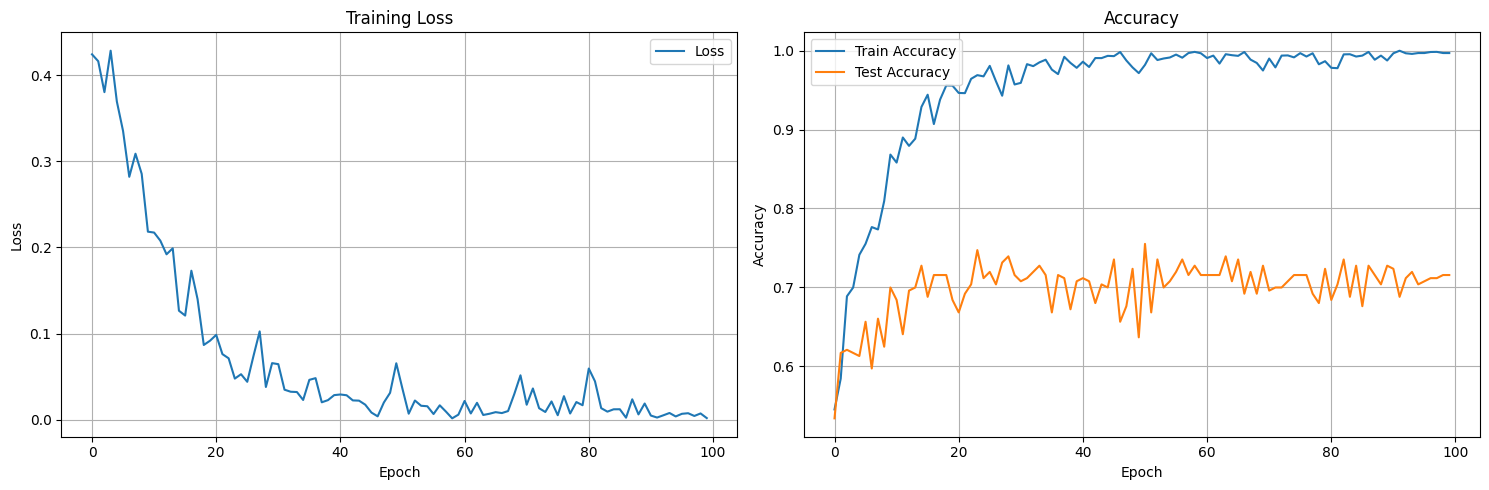

In [6]:
import os 
import random
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split, ConcatDataset
from glob import glob
import matplotlib.pyplot as plt
import CNN_model

# Parameter und Dateneinstellungen 
data_folder = "data_test"
batch_size = 32
num_epochs = 100 
lr = 0.001
weight_decay = 1e-4

# Gerät 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Benutze Gerät:", device)

# Modelinitilaisierung 
model = CNN_model.CNN_EEG(in_channels = 9, n_classes = 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

# Daten laden & vorbereiten 
file_paths = sorted(glob(os.path.join(data_folder, "*.pt")))
if not file_paths:
    raise FileNotFoundError(f"Keine .pt-Dateien im Ordner '{data_folder}' gefunden.")
train_datasets = []
test_datasets = []
batch_nr = 0
for file_path in file_paths:
    print(f"Lade Batch {batch_nr}: {file_path}")
    dataset = torch.load(file_path)

    positive = [g for g in dataset if g[1].item() == 1]
    negative = [g for g in dataset if g[1].item() == 0]
    
    negative = random.sample(negative, len(positive))
    print(f"postiv {len(positive)}, negative {len(negative)}")
    balanced_data = positive + negative
    random.shuffle(balanced_data)
    
     # Split in Train/Test
    train_size = int(0.8 * len(balanced_data))
    test_size = len(balanced_data) - train_size
    torch.manual_seed(42)
    train_set, test_set = random_split(balanced_data, [train_size, test_size])
    train_datasets.append(train_set)
    test_datasets.append(test_set)

    batch_nr += 1
    
# Globale Loader
train_dataset = ConcatDataset(train_datasets)
test_dataset = ConcatDataset(test_datasets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Trainieren und Evaluieren

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = CNN_model.train_modelold(model, train_loader, optimizer, loss_fn)
    test_acc, _, _ = CNN_model.evaluate_model(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# Modell speichern
torch.save(model.state_dict(), "trained_cnn_withNANs.pth")
print("Modell gespeichert.")

#Prozess plotten
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


In [69]:
import numpy as np
import json
import os
from typing import List, Tuple, Dict, Any
from wettbewerb import get_3montages, load_references

# Pakete aus dem Vorlesungsbeispiel
import mne
from scipy import signal as sig
import ruptures as rpt
import torch 
import torch.nn as nn
from CNN_model import CNN_EEG
from preprocess import process_without_mne
from features import feature_extraction
from CNN_dataset import window_data_evaluate, create_fixed_grid_maps


ImportError: cannot import name '_get_flattened_size' from 'CNN_model' (/home/jupyter-wki_team_3/wki-sose25/CNN_model.py)

In [74]:
###Signatur der Methode (Parameter und Anzahl return-Werte) darf nicht verändert werden
def predict_labels(channels : List[str], data : np.ndarray, fs : float, reference_system: str, model_name : str='model.json') -> Dict[str,Any]:
    '''
    Parameters
    ----------
    channels : List[str]
        Namen der übergebenen Kanäle
    data : ndarray
        EEG-Signale der angegebenen Kanäle
    fs : float
        Sampling-Frequenz der Signale.
    reference_system :  str
        Welches Referenzsystem wurde benutzt, "Bezugselektrode", nicht garantiert korrekt!
    model_name : str
        Name eures Models,das ihr beispielsweise bei Abgabe genannt habt. 
        Kann verwendet werden um korrektes Model aus Ordner zu laden
    Returns
    -------
    prediction : Dict[str,Any]
        enthält Vorhersage, ob Anfall vorhanden und wenn ja wo (Onset+Offset)
    '''

#------------------------------------------------------------------------------
# Euer Code ab hier  

    # Initialisiere Return (Ergebnisse)
    seizure_present = True # gibt an ob ein Anfall vorliegt
    seizure_confidence = 0.5 # gibt die Unsicherheit des Modells an (optional)
    onset = 4.2   # gibt den Beginn des Anfalls an (in Sekunden)
    onset_confidence = 0.99 # gibt die Unsicherheit bezüglich des Beginns an (optional)
    offset = 999999  # gibt das Ende des Anfalls an (optional)
    offset_confidence = 0   # gibt die Unsicherheit bezüglich des Endes an (optional)

    # Modell Aufsetzen
    #model = CNN_EEG(in_channels=9, n_classes=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = torch.load(model_name, map_location=device)
    model.to(device)
    model.eval()
    
    #Daten vorbereiten
    window_size = 4.0
    step_size = 1
    standard_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    n_nodes = len(standard_channels)

    processed_input = process_without_mne(data, fs, channels, reference_system, fs)
    
    channel_map = {ch: idx for idx, ch in enumerate(channels)}
    pad_data = np.zeros((n_nodes, processed_input.shape[1]))
    for j, ch in enumerate(standard_channels):
        if ch in channel_map:
            pad_data[j] = processed_input[channel_map[ch]]
    
    windows = window_data_evaluate(pad_data, fs, window_size, step_size)
    data_for_class = []
    # Feature extraction and brain map calculation
    for win in windows:
        features = feature_extraction(win, fs) # shape: (n_channels, n_features)
        assert not np.isnan(features).any(), "NaN in features!"
        brain_map = create_fixed_grid_maps(features, channels)
        assert not np.isnan(brain_map).any(), "NaN in brain_map!"
        x = torch.tensor(brain_map, dtype = torch.float)
        data_for_class.append(x)
        
    
    # Klassifikation
    predictions_per_window =[]
    with torch.no_grad():
        for feature_map in data_for_class:
            feature_map = feature_map.unsqueeze(0).to(device)
            output = model(feature_map)
            predicted_class = torch.argmax(output, dim=1).item()
            predictions_per_window.append(predicted_class)
    
    seizure_present = False
    if 1 in predictions_per_window:
        seizure_present = True
        first_idx = predictions_per_window.index(1)
        time_first = first_idx * step_size
        onset = time_first
        #------------------------------------------------------------------------------  
    prediction = {"seizure_present":seizure_present,"seizure_confidence":seizure_confidence,
                   "onset":onset,"onset_confidence":onset_confidence,"offset":offset,
                   "offset_confidence":offset_confidence}
  
    return prediction # Dictionary mit prediction - Muss unverändert bleiben!

In [75]:
training_folder = "../shared_data/training_mini"
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder,99)
data = data[0]
sampling_frequencies = sampling_frequencies[0]
channels =channels[0]
predict_labels(channels,data,sampling_frequencies,reference_systems,"small_trained_cnn_weights.pth")

1	 Dateien wurden geladen.


/tmp/ipykernel_2452591/3462615070.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_name, map_location=device)


{'seizure_present': True,
 'seizure_confidence': 0.5,
 'onset': 16,
 'onset_confidence': 0.99,
 'offset': 999999,
 'offset_confidence': 0}